In [1]:
import pandas as pd
import requests

# ------------------------------
# 1) CONFIGURAÇÕES
# ------------------------------
COUNTRIES = ["USA","DEU","BRA","ESP","ITA","FRA","GBR","PRT",
             "SWE","CHE","RUS","CHN","JPN"]
START, END = 1990, 2024

# ------------------------------
# 2) FUNÇÃO PARA BAIXAR DADOS DO WORLD BANK
# ------------------------------
def get_worldbank_data(indicator, countries, start, end):
    url = (
        f"https://api.worldbank.org/v2/country/{';'.join(countries)}/indicator/{indicator}?"
        f"date={start}:{end}&per_page=20000&format=json"
    )
    r = requests.get(url)
    r.raise_for_status()

    raw = r.json()
    if raw is None or len(raw) < 2 or raw[1] is None:
        print(f"Nenhum dado encontrado para {indicator}")
        return pd.DataFrame(columns=["country_name","iso3","year",indicator])

    data = raw[1]
    df = pd.json_normalize(data)

    df = df.rename(columns={
        "country.value": "country_name",
        "countryiso3code": "iso3",
        "date": "year",
        "value": indicator
    })[["country_name","iso3","year",indicator]]

    df["year"] = df["year"].astype(int)
    return df

# ------------------------------
# 3) INDICADORES DO WORLD BANK
# ------------------------------
# Despesa do governo (% PIB)
gov_pct = get_worldbank_data("GC.XPN.TOTL.GD.ZS", COUNTRIES, START, END)
gov_pct.rename(columns={"GC.XPN.TOTL.GD.ZS": "gov_expense_gdp_pct"}, inplace=True)

# PIB em US$ correntes
pib_usd = get_worldbank_data("NY.GDP.MKTP.CD", COUNTRIES, START, END)
pib_usd.rename(columns={"NY.GDP.MKTP.CD": "gdp_usd"}, inplace=True)

# População
pop_df = get_worldbank_data("SP.POP.TOTL", COUNTRIES, START, END)
pop_df.rename(columns={"SP.POP.TOTL": "population"}, inplace=True)

# ------------------------------
# 4) CALCULA DESPESA DO GOVERNO EM US$
# ------------------------------
gov_expenses = gov_pct.merge(pib_usd, on=["country_name","iso3","year"], how="outer")
gov_expenses["gov_expense_usd"] = (gov_expenses["gov_expense_gdp_pct"] / 100) * gov_expenses["gdp_usd"]

# ------------------------------
# 5) IDH (Our World in Data)
# ------------------------------
id_df = pd.read_json("hdr-data.json")

id_df = id_df.rename(columns={
    "country": "country_name",
    "countryIsoCode": "iso3",
    "value": "idh"
})

id_df = id_df[["country_name",
               "iso3",
               "year",
               "idh"
              ]]

# Substitui nulos em iso3 pelo próprio nome (caso não haja código disponível)
id_df["iso3"] = id_df["iso3"].fillna(id_df["country_name"])

# Filtra apenas países e período de interesse
id_df = id_df[id_df["iso3"].isin(COUNTRIES) & id_df["year"].between(START, END)]

# ------------------------------
# 6) MERGE FINAL
# ------------------------------
final_df = gov_expenses.merge(pop_df, on=["country_name","iso3","year"], how="outer")
final_df = final_df.merge(id_df, on=["country_name","iso3","year"], how="left")
final_df.sort_values(["iso3","year"], inplace=True)

# Exibe amostra
final_df.head()

# Salva CSV consolidado
#final_df.to_csv("dados_gov_idh_pop_1990_2024.csv", index=False)
#print("Arquivo salvo: dados_gov_idh_pop_1990_2024.csv")

,country_name,iso3,year,gov_expense_gdp_pct,gdp_usd,gov_expense_usd,population,idh
0,Brazil,BRA,1990,NaN,3.849598e+11,NaN,149143223,0.641
1,Brazil,BRA,1991,NaN,3.425341e+11,NaN,151724256,0.645
2,Brazil,BRA,1992,NaN,3.281919e+11,NaN,154275079,0.648
3,Brazil,BRA,1993,NaN,3.682920e+11,NaN,156794577,0.654
4,Brazil,BRA,1994,NaN,5.253695e+11,NaN,159265006,0.659


In [2]:
check_data_df = final_df[['country_name']].drop_duplicates().sort_values('country_name').reset_index(drop=True)

In [3]:
# file: year_nan_check.py

import pandas as pd

# Exemplo: assumindo que final_df já existe

colunas_criticas = [
    "gov_expense_gdp_pct",
    "gdp_usd",
    "gov_expense_usd",
    "population",
    "idh",
]

resultado = []

for iso, grupo in final_df.groupby("iso3"):
    for col in colunas_criticas:
        nao_nan = grupo[grupo[col].notna()]

        if nao_nan.empty:
            resultado.append({
                "iso3": iso,
                "coluna": col,
                "menor_ano": None,
                "maior_ano": None,
                "nan_entre": None,
                "quantidade_dados": None
            })
            continue

        menor_ano = nao_nan["year"].min()
        maior_ano = nao_nan["year"].max()
        quantidade_dados = maior_ano - menor_ano

        intervalo = grupo[(grupo["year"] >= menor_ano) & (grupo["year"] <= maior_ano)]
        nan_entre = intervalo[col].isna().any()

        resultado.append({
            "iso3": iso,
            "coluna": col,
            "menor_ano": menor_ano,
            "maior_ano": maior_ano,
            "nan_entre": nan_entre,
            "quantidade_dados":quantidade_dados
        })

resultado_df = pd.DataFrame(resultado)
resultado_df

,iso3,coluna,menor_ano,maior_ano,nan_entre,quantidade_dados
0,BRA,gov_expense_gdp_pct,2010.0,2023.0,False,13.0
1,BRA,gdp_usd,1990.0,2024.0,False,34.0
2,BRA,gov_expense_usd,2010.0,2023.0,False,13.0
3,BRA,population,1990.0,2024.0,False,34.0
4,BRA,idh,1990.0,2023.0,False,33.0
...,...,...,...,...,...,...
60,USA,gov_expense_gdp_pct,1990.0,2023.0,False,33.0
61,USA,gdp_usd,1990.0,2024.0,False,34.0
62,USA,gov_expense_usd,1990.0,2023.0,False,33.0
63,USA,population,1990.0,2024.0,False,34.0


In [4]:
resultado_df[resultado_df['coluna'].isin(['gov_expense_usd','idh'])]

,iso3,coluna,menor_ano,maior_ano,nan_entre,quantidade_dados
2,BRA,gov_expense_usd,2010.0,2023.0,False,13.0
4,BRA,idh,1990.0,2023.0,False,33.0
7,CHE,gov_expense_usd,1990.0,2023.0,False,33.0
9,CHE,idh,1990.0,2023.0,False,33.0
12,CHN,gov_expense_usd,NaN,NaN,None,NaN
14,CHN,idh,1990.0,2023.0,False,33.0
17,DEU,gov_expense_usd,1990.0,2022.0,False,32.0
19,DEU,idh,1990.0,2023.0,False,33.0
22,ESP,gov_expense_usd,1990.0,2023.0,True,33.0
24,ESP,idh,1990.0,2023.0,False,33.0


In [5]:
COUNTRIES = ['CHE','DEU','ESP','FRA','ITA','JPN','PRT','RUS','SWE','USA']
START, END = 1990, 2023

In [6]:
final_df = final_df[(final_df['iso3'].isin(COUNTRIES)) & (final_df['year']>= START) & (final_df['year']<= END)].reset_index()

#GOV_EXPENSE_USD_PER_CAPITA X IDH

In [7]:
x_val = 'gov_exp_per_capita'
y_val = 'idh'

gov_exp_x_idh_df = final_df

gov_exp_x_idh_df['gov_exp_per_capita'] = gov_exp_x_idh_df['gov_expense_usd']/gov_exp_x_idh_df['population']

gov_exp_x_idh_df = gov_exp_x_idh_df[['country_name','year','gov_exp_per_capita','idh']]

/tmp/ipykernel_395136/675927853.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g["gov_exp_per_capita"].corr(g["idh"]))


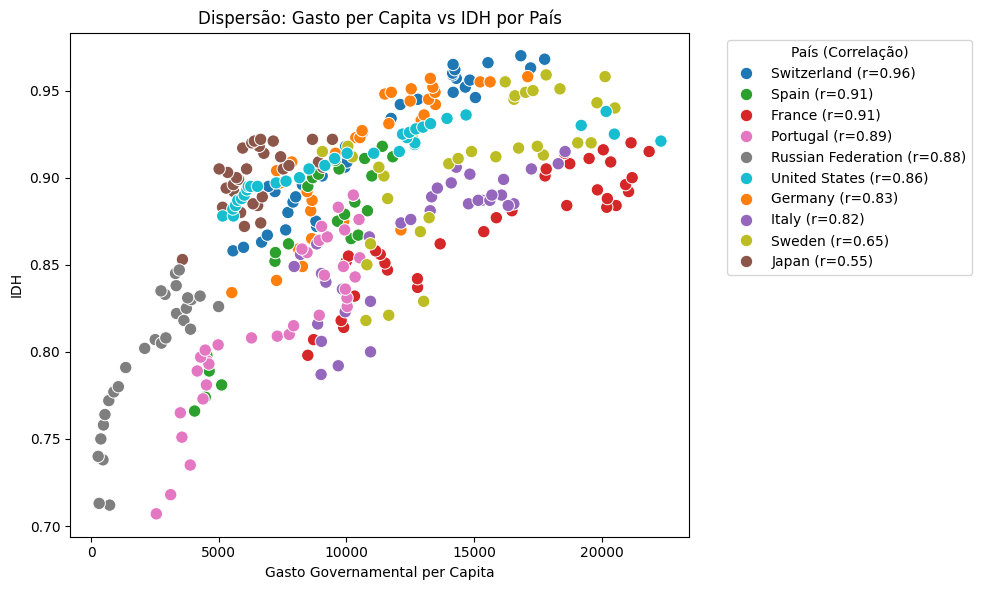

         country_name  correlacao
8         Switzerland    0.957808
6               Spain    0.911202
0              France    0.910188
4            Portugal    0.890098
5  Russian Federation    0.881947
9       United States    0.856025
1             Germany    0.826589
2               Italy    0.817014
7              Sweden    0.648423
3               Japan    0.554272


In [8]:
# file: scatterplot_country.py

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Exemplo: assumindo que gov_exp_x_idh_df já existe

# 1. Calcular correlação por país
correlacoes = (
    gov_exp_x_idh_df.groupby("country_name")
    .apply(lambda g: g["gov_exp_per_capita"].corr(g["idh"]))
    .reset_index(name="correlacao")
)

# Ordenar pela correlação (decrescente)
correlacoes = correlacoes.sort_values(by="correlacao", ascending=False)

# 2. Mapear correlação para legenda
legenda_map = dict(zip(correlacoes["country_name"], correlacoes["correlacao"]))

plt.figure(figsize=(10,6))

sns.scatterplot(
    data=gov_exp_x_idh_df,
    x="gov_exp_per_capita",
    y="idh",
    hue="country_name",
    palette="tab10",
    s=80
)

# Ajustar legenda com índice de correlação (ordenada)
handles, labels = plt.gca().get_legend_handles_labels()

# Reordenar handles e labels conforme a ordem das correlações
ordered_labels = [f"{row.country_name} (r={row.correlacao:.2f})" for row in correlacoes.itertuples()]
ordered_handles = [handles[labels.index(row.country_name)] for row in correlacoes.itertuples()]

plt.legend(ordered_handles, ordered_labels, title="País (Correlação)", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Dispersão: Gasto per Capita vs IDH por País")
plt.xlabel("Gasto Governamental per Capita")
plt.ylabel("IDH")
plt.tight_layout()
plt.show()

# 3. Exibir tabela de correlação ordenada
print(correlacoes)

In [9]:
gov_exp_x_idh_df_USA = gov_exp_x_idh_df.loc[gov_exp_x_idh_df['country_name']=='United States']

In [10]:
gov_exp_x_idh_df_USA.columns

Index(['country_name', 'year', 'gov_exp_per_capita', 'idh'], dtype='object')

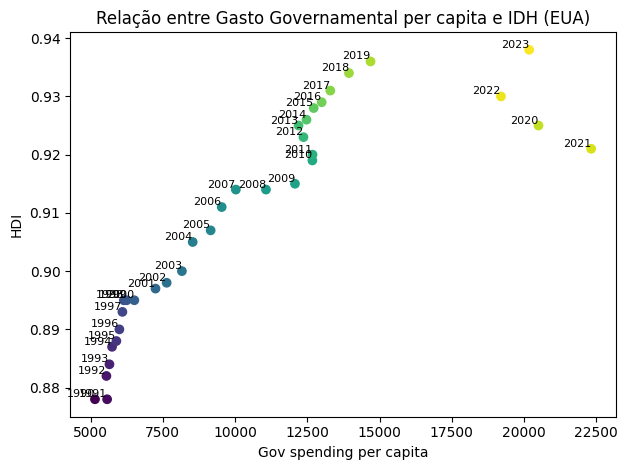

In [11]:
fig, ax = plt.subplots()

ax.scatter(
    x=gov_exp_x_idh_df_USA['gov_exp_per_capita'],
    y=gov_exp_x_idh_df_USA['idh'],
    c=gov_exp_x_idh_df_USA.index
)

# Adiciona rótulos com o ano de cada ponto
for i, year in enumerate(gov_exp_x_idh_df_USA['year']):
    ax.text(
        gov_exp_x_idh_df_USA['gov_exp_per_capita'].iloc[i],
        gov_exp_x_idh_df_USA['idh'].iloc[i],
        str(year),
        fontsize=8,
        ha='right',  # alinhamento horizontal
        va='bottom', # alinhamento vertical
        color='black'
    )

ax.set_ylabel('HDI')
ax.set_xlabel('Gov spending per capita')
ax.set_title('Relação entre Gasto Governamental per capita e IDH (EUA)')

plt.tight_layout()
plt.show()

In [12]:
id_df = pd.read_json("hdr-data (2).json")

id_df

,countryIsoCode,country,indexCode,index,dimension,indicatorCode,indicator,year,value,note
0,AFG,Afghanistan,HDI,Human Development Index,,eys,Expected Years of Schooling (years),1990,2.936460,
1,AFG,Afghanistan,HDI,Human Development Index,,eys,Expected Years of Schooling (years),1991,3.228456,
2,AFG,Afghanistan,HDI,Human Development Index,,eys,Expected Years of Schooling (years),1992,3.520452,
3,AFG,Afghanistan,HDI,Human Development Index,,eys,Expected Years of Schooling (years),1993,3.812448,
4,AFG,Afghanistan,HDI,Human Development Index,,eys,Expected Years of Schooling (years),1994,4.104445,
...,...,...,...,...,...,...,...,...,...,...
25494,ZWE,Zimbabwe,HDI,Human Development Index,,mys,Mean Years of Schooling (years),2019,8.687460,
25495,ZWE,Zimbabwe,HDI,Human Development Index,,mys,Mean Years of Schooling (years),2020,8.808313,
25496,ZWE,Zimbabwe,HDI,Human Development Index,,mys,Mean Years of Schooling (years),2021,8.930847,
25497,ZWE,Zimbabwe,HDI,Human Development Index,,mys,Mean Years of Schooling (years),2022,8.930847,
